## Process Synthetic Data with Aurora

This notebook shows how to process MTH5 data from a synthetic dataset.

Steps
1. Create the synthetic mth5
2. Get a Run Summary from the mth5
3. Select the station to process and optionally the remote reference station
4. Create a processing config
5. Generate TFs
6. Archive the TFs (in emtf_xml or z-file)

In [25]:
# Uncomment the following line to make plots interactive.
# %matplotlib widget

### Here are the modules we will need to import 

In [26]:
import pathlib
import warnings

from aurora.config.config_creator import ConfigCreator
from aurora.pipelines.process_mth5 import process_mth5
from aurora.pipelines.run_summary import RunSummary
from aurora.test_utils.synthetic.make_mth5_from_asc import create_test12rr_h5
from aurora.test_utils.synthetic.paths import DATA_PATH
from aurora.transfer_function.kernel_dataset import KernelDataset

warnings.filterwarnings('ignore')

## Define mth5 file

The synthetic mth5 file is used for testing in `aurora/tests/synthetic/` and probably already exists on your system

In [27]:
mth5_path = DATA_PATH.joinpath("test12rr.h5")

But, if it doesn't or you want to re-make it, call `create_test12rr_h5()`

In [28]:
#if not mth5_path.exists():
create_test12rr_h5()   

2022-10-15 14:34:41,846 [line 606] mth5.mth5.MTH5.open_mth5 - WARNING: test12rr.h5 will be overwritten in 'w' mode
2022-10-15 14:34:42,299 [line 673] mth5.mth5.MTH5._initialize_file - INFO: Initialized MTH5 0.1.0 file /home/kkappler/software/irismt/aurora/tests/synthetic/data/test12rr.h5 in mode w
2022-10-15 14:34:45,222 [line 753] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing /home/kkappler/software/irismt/aurora/tests/synthetic/data/test12rr.h5


'/home/kkappler/software/irismt/aurora/tests/synthetic/data/test12rr.h5'

## Get a Run Summary

Note that we didn't need to explicitly open the mth5 to do that, we can pass the path if we want

In [29]:
mth5_run_summary = RunSummary()
mth5_run_summary.from_mth5s([mth5_path,])
run_summary = mth5_run_summary.clone()
run_summary.mini_summary

2022-10-15 14:34:45,307 [line 753] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing /home/kkappler/software/irismt/aurora/tests/synthetic/data/test12rr.h5


survey station_id run_id                     start                       end
0   none      test1    001 1980-01-01 00:00:00+00:00 1980-01-01 11:06:40+00:00
1   none      test2    001 1980-01-01 00:00:00+00:00 1980-01-01 11:06:40+00:00

## Define a Kernel Dataset


In [30]:
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, "test1", "test2")
kernel_dataset.mini_summary

survey station_id run_id                     start                       end
0   none      test1    001 1980-01-01 00:00:00+00:00 1980-01-01 11:06:40+00:00
1   none      test2    001 1980-01-01 00:00:00+00:00 1980-01-01 11:06:40+00:00

## Now define the processing Configuration

The only things we need to provide are our band processing scheme, and the data sample rate to generate a default processing configuration.

The config is then told about the stations via the kernel dataset.

**When doing only single station processing you need to specify RME processing (rather than remote reference processing which expects extra time series from another station)

In [37]:
cc = ConfigCreator()
config = cc.create_from_kernel_dataset(kernel_dataset)

Bands not defined; setting to EMTF BANDS_DEFAULT_FILE
/home/kkappler/software/irismt/aurora/aurora/config/emtf_band_setup/bs_test.cfg
OK


In [38]:
for decimation in config.decimations:
    decimation.window.type = "hamming"

## Call process_mth5

DATASET DF POPULATED
Processing config indicates 4 decimation levels 
DATASET DF UPDATED
Processing band 25.728968s
Processing band 19.929573s
Processing band 15.164131s
Processing band 11.746086s
Processing band 9.195791s
Processing band 7.362526s
Processing band 5.856115s
Processing band 4.682492s


DECIMATION LEVEL 1
DATASET DF UPDATED
Processing band 102.915872s
Processing band 85.631182s
Processing band 68.881694s
Processing band 54.195827s
Processing band 43.003958s
Processing band 33.310722s


DECIMATION LEVEL 2
DATASET DF UPDATED
Processing band 411.663489s
Processing band 342.524727s
Processing band 275.526776s
Processing band 216.783308s
Processing band 172.015831s
Processing band 133.242890s


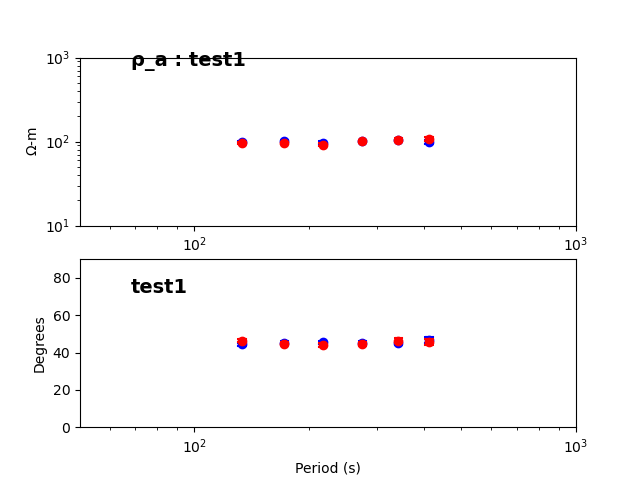

DECIMATION LEVEL 3
DATASET DF UPDATED
Processing band 1514.701336s
Processing band 1042.488956s
Processing band 723.371271s
Processing band 532.971560s
Processing band 412.837995s


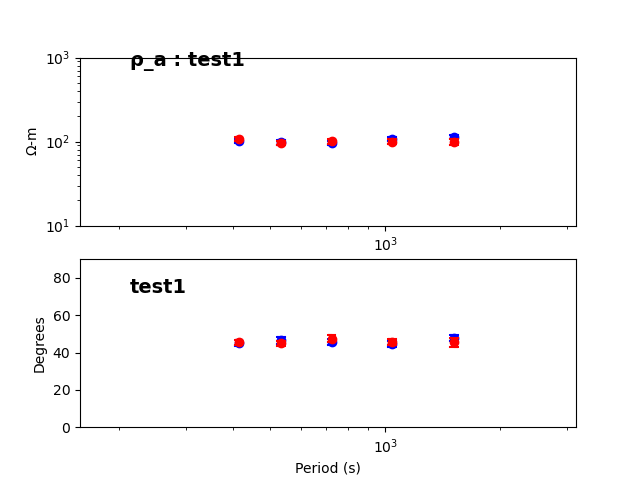

2022-10-15 14:36:38,143 [line 753] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing /home/kkappler/software/irismt/aurora/tests/synthetic/data/test12rr.h5
2022-10-15 14:36:38,145 [line 753] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing /home/kkappler/software/irismt/aurora/tests/synthetic/data/test12rr.h5


In [39]:
show_plot = True
tf_cls = process_mth5(config,
                    kernel_dataset,
                    units="MT",
                    show_plot=show_plot,
                    z_file_path=None,
                )

In [34]:
xml_file_base = f"synthetic_test1.xml"
tf_cls.write_tf_file(fn=xml_file_base, file_type="emtfxml")


2022-10-15 14:34:55,738 [line 205] mt_metadata.transfer_functions.io.readwrite.write_file - INFO: Wrote synthetic_test1.xml


EMTFXML(station='test1', latitude=0.00, longitude=0.00, elevation=0.00)

### The Default Processing Configuration is "tuned"

We can modify some of the processing parameters.  Here is an example that shows a more naive processing configuration can give less trustworthy results.

In [35]:
for decimation in config.decimations:
    decimation.prewhitening_type =  ""
    decimation.window.type = "boxcar"

DATASET DF POPULATED
Processing config indicates 4 decimation levels 
DATASET DF UPDATED
Processing band 25.728968s
Processing band 19.929573s
Processing band 15.164131s
Processing band 11.746086s
Processing band 9.195791s
Processing band 7.362526s
Processing band 5.856115s
Processing band 4.682492s


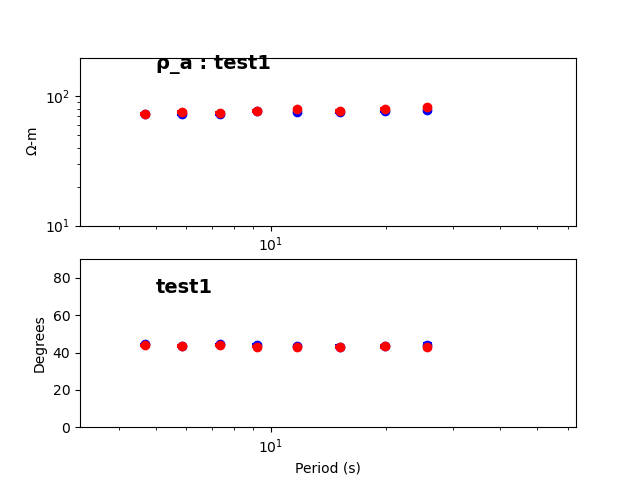

DECIMATION LEVEL 1
DATASET DF UPDATED
Processing band 102.915872s
Processing band 85.631182s
Processing band 68.881694s
Processing band 54.195827s
Processing band 43.003958s
Processing band 33.310722s


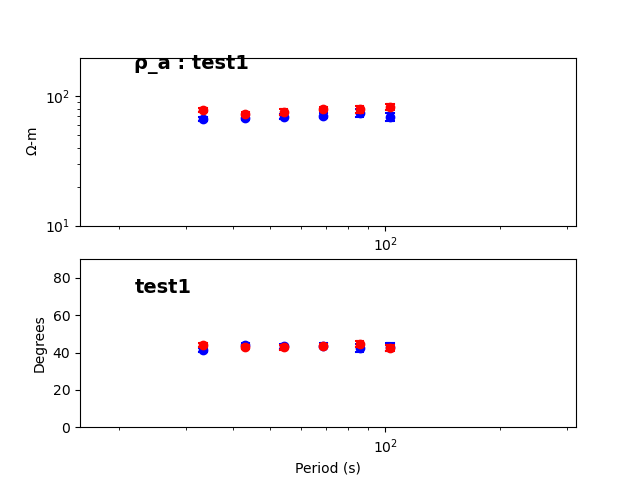

DECIMATION LEVEL 2
DATASET DF UPDATED
Processing band 411.663489s
Processing band 342.524727s
Processing band 275.526776s
Processing band 216.783308s
Processing band 172.015831s
Processing band 133.242890s


DECIMATION LEVEL 3
DATASET DF UPDATED
Processing band 1514.701336s
Processing band 1042.488956s
Processing band 723.371271s
Processing band 532.971560s
Processing band 412.837995s


2022-10-15 14:35:05,956 [line 753] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing /home/kkappler/software/irismt/aurora/tests/synthetic/data/test12rr.h5
2022-10-15 14:35:05,957 [line 753] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing /home/kkappler/software/irismt/aurora/tests/synthetic/data/test12rr.h5


In [36]:
show_plot = True
tf_cls = process_mth5(config,
                    kernel_dataset,
                    units="MT",
                    show_plot=show_plot,
                    z_file_path=None,
                )